In [ ]:
import os

# Import installed libraries
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

# Scikit-Learn stuff
import sklearn
from sklearn import preprocessing
from sklearn.model_selection import StratifiedShuffleSplit

# Keras
import tensorflow.keras as keras
import tensorflow as tf

# Matplotlib settings
# Set the dark mode and the font size and style
plt.style.use('dark_background')
plt.rc('font', family='serif', size=18)

In [ ]:
# Set seeds to create reproducible experiments
np.random.seed(1)
tf.random.set_seed(1)

In [ ]:
try:
    from google.colab import drive
    drive.mount('/gdrive')
    core_path = "/path name/"
except ModuleNotFoundError:
    core_path = ""

# Load the level 2 asteroid data
asteroids_df = pd.read_pickle(os.path.join(core_path, "data/lvl2/", "asteroids.pkl"))

# Allocate the spectra to one array and the classes to another one
asteroids_X = np.array([k["Reflectance_norm550nm"].tolist() for k in asteroids_df["SpectrumDF"]])
asteroids_y = np.array(asteroids_df["Main_Group"].to_list())
asteroids_y_bus = np.array(asteroids_df["Bus_Class"].to_list())

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [ ]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2)

# Create a simple, single train / test split
for train_index, test_index in sss.split(asteroids_X, asteroids_y):

    X_train, X_test = asteroids_X[train_index], asteroids_X[test_index]
    y_train, y_test = asteroids_y[train_index], asteroids_y[test_index]
    y_train_bus, y_test_bus = asteroids_y_bus[train_index], asteroids_y_bus[test_index]

In [ ]:
from sklearn import preprocessing

# Instantiate the StandardScaler (mean 0, standard deviation 1) and use the training data to fit
# the scaler
scaler = preprocessing.StandardScaler().fit(X_train)

# Transform now the training data
X_train_scaled = scaler.transform(X_train)

# Scale the testing data ...
X_test_scaled = scaler.transform(X_test)

# And expanding the dimensionality for our ConvNet-based Autoencoder
X_train_scaled = np.expand_dims(X_train_scaled, axis=2)
X_test_scaled = np.expand_dims(X_test_scaled, axis=2)

In [ ]:
import keras
from keras.layers import Input, Conv1D, Conv1DTranspose, LeakyReLU, BatchNormalization, Flatten, Dense, Reshape
from keras.models import Model
from keras.optimizers import Adam

n_inputs = asteroids_X.shape[1]
n_bottleneck = 2

def create_model():
    input_layer = Input(shape=(n_inputs, 1))
    x = BatchNormalization()(input_layer)  # Add batch normalization

    x = Conv1D(filters=16, kernel_size=3, activation=LeakyReLU(alpha=0.2), padding="same")(x)
    x = Conv1D(filters=32, kernel_size=3, activation=LeakyReLU(alpha=0.2), padding="same")(x)

    bottleneck_lay = Flatten()(x)
    bottleneck_lay = Dense(n_bottleneck)(bottleneck_lay)

    reset_lay = Dense(49 * 32)(bottleneck_lay)
    reshape_lay = Reshape((49, 32))(reset_lay)

    x = Conv1DTranspose(filters=32, kernel_size=3, strides=1, activation=LeakyReLU(alpha=0.2), padding="same")(reshape_lay)
    x = Conv1DTranspose(filters=16, kernel_size=3, strides=1, activation=LeakyReLU(alpha=0.2), padding="same")(x)

    output_layer = Conv1D(1, 1, padding="same")(x)

    model = Model(inputs=input_layer, outputs=output_layer)
    encoder_model = Model(inputs=input_layer, outputs=bottleneck_lay)

    return model, encoder_model

model, encoder_model = create_model()

# Use a custom optimizer with a specific learning rate
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse')

model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 49, 1)]           0         
                                                                 
 batch_normalization_1 (Bat  (None, 49, 1)             4         
 chNormalization)                                                
                                                                 
 conv1d_2 (Conv1D)           (None, 49, 16)            64        
                                                                 
 conv1d_3 (Conv1D)           (None, 49, 32)            1568      
                                                                 
 flatten (Flatten)           (None, 1568)              0         
                                                                 
 dense (Dense)               (None, 2)                 3138      
                                                             

In [ ]:
end_epoch = 500
batch_size = 32

# Early Stopping for our final model
es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(X_train_scaled, X_train_scaled,
                    epochs=end_epoch,
                    batch_size=batch_size,
                    verbose=0,
                    validation_split=0.25,
                    callbacks=[es_callback])

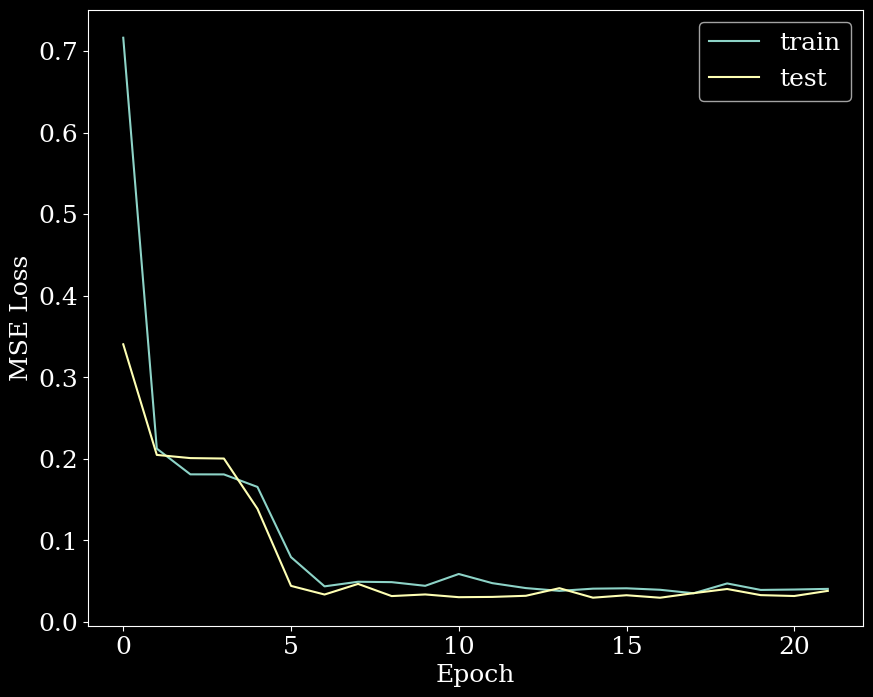

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')

# Add legend and labels
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")

# ... aaaaand plot!
plt.show()

In [ ]:
#Signal Reconstruction

34/34 [==============================] - 0s 5ms/step


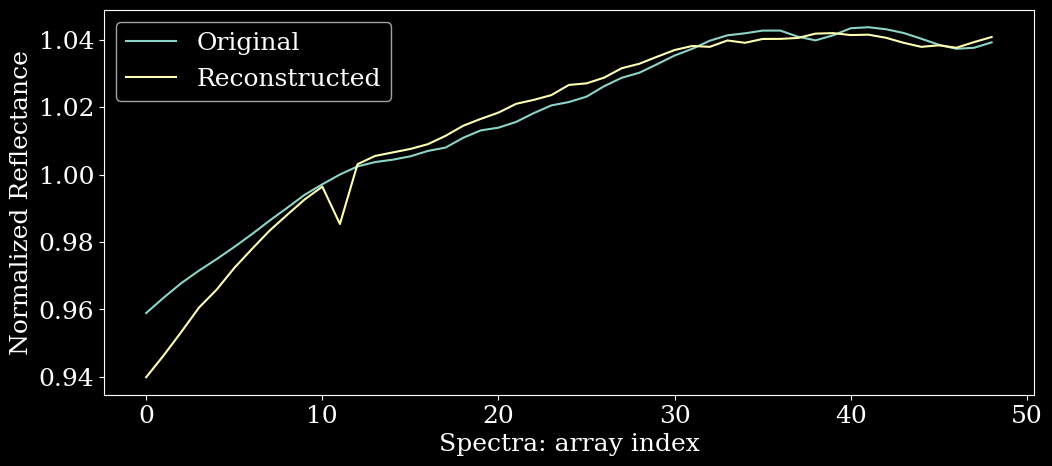

In [ ]:
index_val = 5

# Original signal
org_signal = scaler.inverse_transform(X_train_scaled[index_val].reshape(1, -1))[0]
# Reconstructed signal
rec_signal = scaler.inverse_transform(model.predict(X_train_scaled)[index_val].reshape(1, -1))[0]

# plot the training and reconstructed data
plt.figure(figsize=(12,5))
plt.plot(org_signal, label='Original')
plt.plot(rec_signal, label='Reconstructed')

# Add legend and labels
plt.legend()
plt.xlabel("Spectra: array index")
plt.ylabel("Normalized Reflectance")

plt.show()